In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cv2
from scipy.fft import fft2, ifft2
from sklearn.cluster import KMeans

In [139]:
def show_heat_map(data = np.random.rand(1024, 1280), name='original'):
    """
    绘制热图,配置参数
    """
    data = data * 10
    # 定义自定义的颜色映射，从暗蓝色到绿色再到黄色，并反转颜色顺序
    cmap = ListedColormap(list(reversed(plt.cm.YlGnBu(np.linspace(0, 1, 256)))))

    # 绘制热图，并指定颜色映射和插值方式
    plt.imshow(data, cmap=cmap, interpolation='bilinear')
    plt.clim(0, 7000)
    # 添加颜色条
    plt.colorbar()

    # 添加标题和标签
    plt.title(name)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # 显示图像
    plt.show()

In [140]:
def read_raw(file_root='cube_20221028_104439\ENVI_cube_20221028_104439.raw'):
    """
    读取raw文件，转换成10*1024*1280的数组
    """
    width = 1280
    height = 1024
    channels = 10
    raw_image = np.fromfile(file_root, dtype=np.float16)
    image = raw_image.reshape((channels, height, width))
    image = image * 1.5e6
    
    return image 

In [141]:
def revise_raw(image):
    """
    将raw的值映射至1-7000，并让每个通道相加
    """
    image = image 
    image = np.sum(image, axis=0)
    
    return image

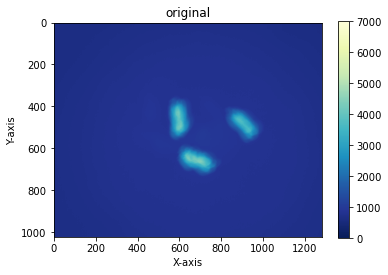

0


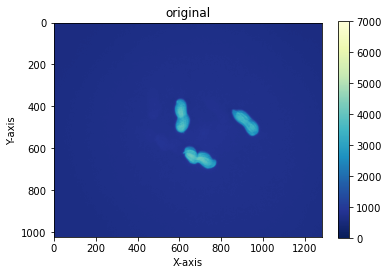

1


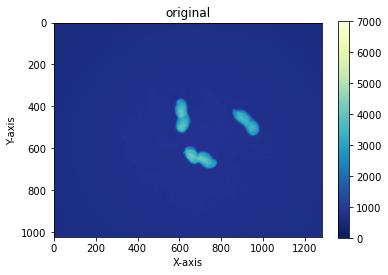

2


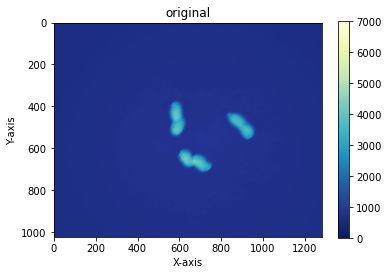

3


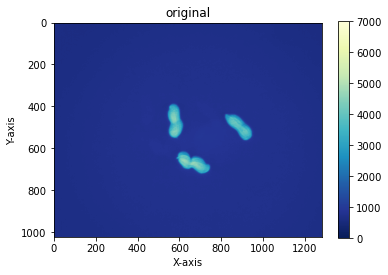

4


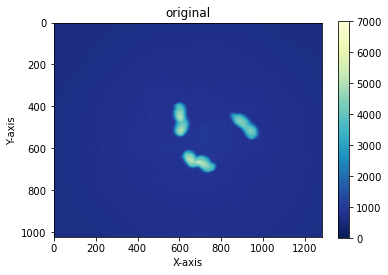

5


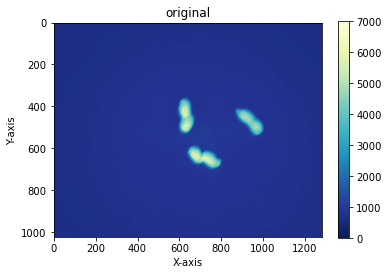

6


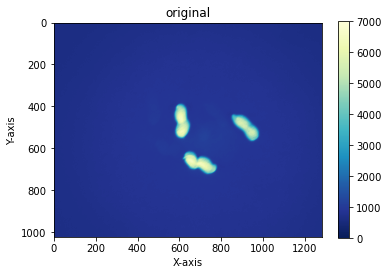

7


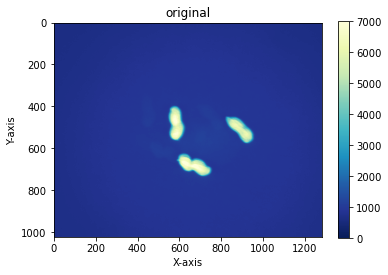

8


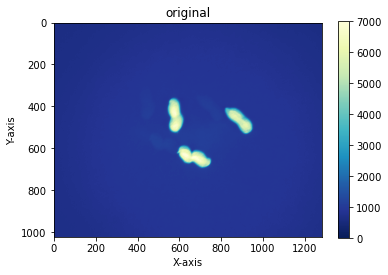

9


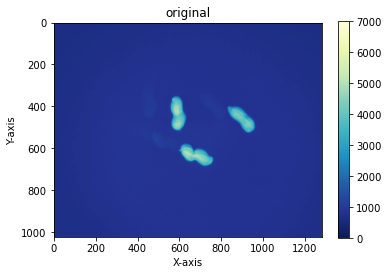

In [142]:
image = read_raw()
result = revise_raw(image)
show_heat_map(result)
for i in range(10):
    print(i)
    show_heat_map(image[i]*10)

In [41]:
# 将图像转换为二维数组
pixels = image[0].reshape(1, -1)
pixels = pixels.reshape(-1, 1)
# 使用K均值聚类进行图像聚类
kmeans = KMeans(n_clusters=2)  # K是聚类的数量
kmeans.fit(pixels)

KMeans(n_clusters=2)

In [42]:
# 获取聚类标签和聚类中心
labels = kmeans.labels_
centers = kmeans.cluster_centers_
# 计算每个类别的个数
counts = np.bincount(labels)

# 打印每个类别的个数
for i, count in enumerate(counts):
    print(f"类别 {i}: {count} 个")


类别 0: 1287120 个
类别 1: 23600 个


In [138]:
def get_min(img):
    """
    获取像素集中度最高通道的索引
    """
    a = 1587120
    count = []
    for i, image in enumerate(img):
        # 计算每个类别的个数
        counts = np.sum(image>20)
        count.append(counts)
        print(counts)

    return count.index(min(count))
get_min(image)

23265
23050
23928
25618
29524
27579
31326
32927
27598
25815


1

In [127]:
def get_best_channel(img):
    """
    获取像素集中度最高通道的索引,以作为基准通道
    """
    a = 1587120
    count = []
    for i, image in enumerate(img):
        # 将图像转换为二维数组
        pixels = image.reshape(1, -1)
        pixels = pixels.reshape(-1, 1)
        # 使用K均值聚类进行图像聚类
        kmeans = KMeans(n_clusters=2)  # K是聚类的数量
        kmeans.fit(pixels)
        # 获取聚类标签和聚类中心
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_
        # 计算每个类别的个数
        counts = np.bincount(labels)
        count.append(min(counts))
        print(min(counts))

    return count.index(min(count))

In [128]:
get_min(image)

23600
24524
25498
26045
31010
24243
25092
25699
23365
23939


8

In [123]:
import cv2
import numpy as np

def align_spectral_images(spectral_data):
    # 获取参考通道（假设第一个通道为参考通道）
    reference_channel = spectral_data[0]

    # 定义输出图像形状
    output_shape = reference_channel.shape[::-1]

    # 创建空白的输出图像数组
    aligned_data = np.zeros_like(spectral_data)

    # 创建SIFT对象
    sift = cv2.SIFT_create()

    # 检测参考通道的特征点
    keypoints_ref, descriptors_ref = sift.detectAndCompute(reference_channel, None)

    # 遍历每个通道，进行图像对齐
    for channel in range(spectral_data.shape[0]):
        # 当前通道的图像
        current_image = spectral_data[channel]

        # 检测当前通道的特征点
        keypoints_cur, descriptors_cur = sift.detectAndCompute(current_image, None)

        # 创建FLANN匹配器
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # 在参考图像和当前图像之间进行特征点匹配
        matches = flann.knnMatch(descriptors_ref, descriptors_cur, k=2)

        # 选择最佳匹配的特征点
        good_matches = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)

        # 检查匹配到的特征点数量是否足够
        if len(good_matches) < 4:
            print("警告：第", channel, "个通道的特征点数量不足，无法进行对齐")
            aligned_data[channel] = current_image
            continue

        # 提取匹配特征点的坐标
        ref_pts = np.float32([keypoints_ref[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        cur_pts = np.float32([keypoints_cur[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        print(ref_pts.shape)
        print(cur_pts.shape)

        # 估计图像的仿射变换矩阵
        M, _ = cv2.estimateAffine2D(cur_pts, ref_pts)

        # 将仿射变换矩阵转换为2x3形状的
        M = np.concatenate([M, np.array([[0, 0, 1]])], axis=0)

        # 将当前通道的图像根据仿射变换矩阵进行像素对齐
        aligned_image = cv2.warpAffine(current_image, M[:2, :], output_shape)

        # 将对齐后的图像保存到输出图像数组中
        aligned_data[channel] = aligned_image

    # 计算评价标准（均方误差）
    mse = np.mean((aligned_data - reference_channel) ** 2)
    print("均方误差 (MSE):", mse)

    return aligned_data

# 调用函数进行测试
spectral_data = np.random.randint(0, 1000, size=(10, 1024, 1280)).astype(np.uint8)
aligned_data = align_spectral_images(spectral_data)


(5536, 1, 2)
(5536, 1, 2)
警告：第 1 个通道的特征点数量不足，无法进行对齐
警告：第 2 个通道的特征点数量不足，无法进行对齐
警告：第 3 个通道的特征点数量不足，无法进行对齐
警告：第 4 个通道的特征点数量不足，无法进行对齐
警告：第 5 个通道的特征点数量不足，无法进行对齐
警告：第 6 个通道的特征点数量不足，无法进行对齐
警告：第 7 个通道的特征点数量不足，无法进行对齐
警告：第 8 个通道的特征点数量不足，无法进行对齐
警告：第 9 个通道的特征点数量不足，无法进行对齐
均方误差 (MSE): 94.94894691467285


In [124]:
# 获取参考通道（假设第一个通道为参考通道）
spectral_data = image.astype(np.uint8)

aligned_data = align_spectral_images(spectral_data)

(14, 1, 2)
(14, 1, 2)
(10, 1, 2)
(10, 1, 2)
(5, 1, 2)
(5, 1, 2)


ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
spectral_data[0].shape

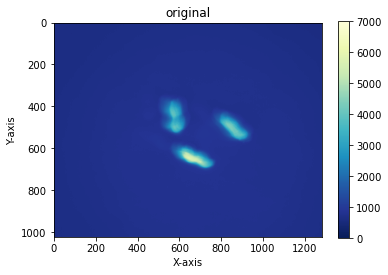

In [76]:
show_heat_map(result)